Parameters in the model
Matrix R: containing the ratings 
Matrix U: Containing the embeddings of the users
Matrix M: Containing the embedding of the movies


In [1]:
#### Packages ####
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
from scipy.sparse import rand as sprand
from torch.utils.data import Dataset, DataLoader
#from torchvision import transforms, utils
from torch.utils import data
from torchtext.data import Dataset, BucketIterator, Field, TabularDataset, Iterator
#from torchtext import data
from torchtext import datasets
import math

%matplotlib inline
from sklearn.metrics import accuracy_score
import matplotlib
import matplotlib.pyplot as plt



import numpy as np

from sklearn.manifold import TSNE

from torchtext import data
from torchtext import datasets

from torch.autograd import Variable

from torch.nn import Linear, RNN, LSTM

from sklearn.manifold import TSNE

from sklearn.metrics import accuracy_score

# we'll use the bokeh library to create beautiful plots
# *_notebook functions are needed for correct use in jupyter
#from bokeh.plotting import figure, ColumnDataSource
#from bokeh.models import HoverTool
#from bokeh.io import output_notebook, show, push_notebook
#output_notebook()


In [2]:
# The grand dataset
ratings_df = pd.read_csv('ratings_small.csv', usecols = ['userId','movieId','rating'])

#ratings

In [3]:
#### Creating new indices ####
def zero_indexing(column):
    uniq = column.unique()
    newindex = {o:i for i,o in enumerate(uniq)}
    # Subtracting 1 from the original ID's
    return newindex, np.array([newindex.get(x, -1) for x in column])

_,usercol = zero_indexing(ratings_df["userId"])
_,moviecol = zero_indexing(ratings_df["movieId"])

ratings_df["userId"] = usercol
ratings_df["movieId"] = moviecol

# Removing ID's which are less than 0
ratings_dataset = ratings_df[ratings_df["userId"] >= 0]
ratings_dataset = ratings_df[ratings_df["movieId"] >= 0]

print("Printing head of dataset with new IDs: ")
print(ratings_dataset.head())

Printing head of dataset with new IDs: 
   userId  movieId  rating
0       0        0     2.5
1       0        1     3.0
2       0        2     3.0
3       0        3     2.0
4       0        4     4.0


In [4]:
#### Splitting dataset into training, validation and test sets ####
n = len(ratings_dataset)
sizes = [0.7, 0.2, 0.1]
train_size = int(sizes[0]*n)
val_size = int(sizes[1]*n)
test_size = int(sizes[2]*n)

train_set = ratings_dataset[:train_size-1].copy() # till 70002-1 = 70001
val_set = ratings_dataset[train_size:-test_size-1].copy() # from 70002 to 100.004 - 20000
test_set = ratings_dataset[train_size+val_size:].copy() # from train+val size

print("Entire dataset: ", n)
print("Train size: ", train_set.shape[0])
print("Validation size: ", val_set.shape[0])
print("Test size: ", test_set.shape[0])
print("Checking if dimensions match: ", train_set.shape[0] + val_set.shape[0] + test_set.shape[0] == n )


Entire dataset:  100004
Train size:  70001
Validation size:  20001
Test size:  10002
Checking if dimensions match:  True


In [5]:
#### Creating a dataformatting to format the data ####
class dataformatting(Dataset):
    def __init__(self, users, movies, rating):
        self.movies = movies
        self.users = users
        self.rating = rating
        
    def __len__(self):
        return len(self.rating)

    def __getitem__(self, index):
        u = self.users[index]
        m = self.movies[index]
        r = self.rating[index]
        #obs = {'movieId':movieId,'userId':userId,'rating':rating}
        #obs = self.movieLens.drop('timestamp',axis=1)
        #obs = obs.iloc[index,:].as_matrix()
        return [u, m, r]

In [6]:
#### Formatting training, validation and training sets ####
u_train = torch.LongTensor(train_set.userId.values)
m_train = torch.LongTensor(train_set.movieId.values)
r_train = torch.FloatTensor(train_set.rating.values)

train_dataset = dataformatting(u_train, m_train, r_train)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)

u_val = torch.LongTensor(val_set.userId.values)
m_val = torch.LongTensor(val_set.movieId.values)
r_val = torch.FloatTensor(val_set.rating.values)
val_dataset = dataformatting(u_val, m_val,r_val)
val_iter = torch.utils.data.DataLoader(val_dataset, batch_size=100, shuffle=True)

u_test = torch.LongTensor(test_set.userId.values)
m_test = torch.LongTensor(test_set.movieId.values)
r_test = torch.FloatTensor(test_set.rating.values)
test_dataset = dataformatting(u_test, m_test, r_test)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=True)



In [7]:
# Printing one batch from the train dataloader
#t1= iter(train_iter)
#next(t1)


# MODEL

In [8]:
n_hidden=60
num_user = len(ratings_dataset.userId.unique()) 
num_movie = len(ratings_dataset.movieId.unique())
emb_size = 100

class FFNN(nn.Module):
    def __init__(self, num_user, num_movie, emb_size):
        super(FFNN, self).__init__()
        self.userEmb = nn.Embedding(num_user, emb_size)
        self.movieEmb = nn.Embedding(num_movie, emb_size)
        
        self.lin = nn.Linear(in_features = emb_size*2, out_features= n_hidden, bias=True)
        self.lin2 = nn.Linear(in_features = n_hidden, out_features=n_hidden,bias = True)
        
        self.lin3 = nn.Linear(in_features = n_hidden, out_features=1,bias = True)
        
        self.drop1 = nn.Dropout(0.15)
        self.drop2 = nn.Dropout(0.15)
        self.drop3 = nn.Dropout(0.05)
        
    def forward(self, u, v):
        
        U = self.userEmb(u)
        V = self.movieEmb(v)
        x = torch.cat([U, V], dim=1)
      
    
        x = self.drop1(x)
        x = self.lin(x)
       
        x = F.relu(x)
        
        
        x = self.drop2(x)
        x = self.lin2(x)
        
        
        x = F.relu(x)
        
        x = self.drop3(x)
        x = self.lin3(x)
       
      
        return torch.sigmoid(x)*4 + 1
    
    
    

In [9]:
## testing whether the model works
#model=FFNN(num_user,num_movie,emb_size)
#[p for p in model.parameters()]

In [16]:
def train(model, train_iter, optimizer, epoch,print_batch_p):
    #def train_epocs(model, train_iter, optimizer, criterion, epoch):
    
    
    ###
    def train(model, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0
    for (users, items, ratings) in train_loader:
        users = users.long().to(device)
        items = items.long().to(device)
        ratings = ratings.float().to(device)
        ratings = ratings.unsqueeze(1)
        
        optimizer.zero_grad()
        output = model(users, items)
        loss = criterion(output, ratings)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
    return train_loss / len(train_loader)
    
    ###
    
    model.train() # into training mode
    running_loss = 0.
    acc_list = []
    loss_list = []
    loss_mean = []
    acc_mean =[]
           
    for j, data in enumerate(train_iter):
        users, items, ratings = data
        batch_size = len(users)
        users = Variable(users)
        items = Variable(items)
        ratings = Variable(ratings).float()
        ratings= ratings.unsqueeze(1)
        y_hat = model(users, items)
        
        loss = F.mse_loss(y_hat, ratings)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print per percent
        percent = print_batch_p
        proc = (int((len(train_iter.dataset)/batch_size)*percent))
        proc = proc if proc >= 1 else 1
        
        #calculate accuracy
        TP,FP,TN,FN = 1,0,0,0
        for y, yhat in zip(ratings, y_hat):
            y = int(y)
            if yhat == 0:
                if y != yhat:
                    FN += 1
                else:
                    TN += 1
            else:
                if y != yhat:
                    FP += 1
                else:
                    TP += 1
        acc_list += [(TP + TN)/(TP+FP+TN+FN)]
        loss_list += [loss.item()]
        
        if (j % proc == 0 and j != 0):
            loss_mean = sum(loss_list)/len(loss_list)
            acc_mean = sum(acc_list)/len(acc_list)
            percent = 100 * (j / (len(train_iter)-1))
            print(f'Train epoch {epoch:3d} ({percent:3.0f}%), Mean Accuracy: {acc_mean:2.5f}, Mean Loss: {loss_mean:2.5f}')
            

IndentationError: expected an indented block (<ipython-input-16-f8dbc3912f78>, line 7)

In [11]:
def validate(model, val_iter, epoch):
    #def validate(model, val_iter, criterion, epoch):
    model.eval() # go to evaluation mode
    
    #Helps to measure accuracy
    val_loss = 0
    TP,FP,TN,FN = 0,0,0,0
    
    running_loss = 0.
    for j, data in enumerate(val_iter):
        users, items, ratings = data
        users = Variable(users)
        items = Variable(items)
        ratings = Variable(ratings).float()
        ratings=ratings.unsqueeze(1)
            
        y_hat = model(users, items)
        loss_now = F.mse_loss(y_hat, ratings)
        
        # counts true positive, false negative etc. 
        for y,yhat in zip(ratings.data, y_hat):
                y = int(y)
                if yhat == 0:
                    if y != yhat:
                        FN += 1
                    else:
                        TN += 1
                else:
                    if y != yhat:
                        FP += 1
                    else:
                        TP += 1
        val_loss += loss_now.item() # sum up batch loss
    
    #val_acc = (TP + TN)/(TP + TN + FP + FN)
    val_loss /= len(val_iter)
    print(f'Validation epoch {epoch:>3d} (100%), Mean Loss: {val_loss:>2.5f} \n')
    return  val_loss

In [12]:
def trainLoop(epochs, lr, wd,print_batch_p,early_patience):
    # Define model    
    model = FFNN(num_user, num_movie,emb_size)
    #criterion=F.mse_loss()
    parameters = filter(lambda p: p.requires_grad, model.parameters()) # get all parameters which need grad
    optimizer = torch.optim.Adam(parameters, lr=lr, weight_decay=wd)
    
    losses = []
    best_loss = (-1,-1e16,1e16)
    early = 0
    
    for epoch in range(1,epochs+1):
        train(model, train_iter, optimizer, epoch,print_batch_p )
        val_loss = validate(model, val_iter, epoch)
        losses += [val_loss]
        
        early += 1
        if val_loss < best_loss[-1]:
            early = 0
            best_loss = (epoch, val_loss)
        if early >= early_patience:
            break
        
    plt.plot(range(1,epoch+1),losses)
    plt.show()
    print(f'best validatation loss epoch: {best_loss[0]:>3.0f}, mean loss: {best_loss[2]:>2.5f}')


Validation epoch   1 (100%), Mean Loss: 0.94195 

Validation epoch   2 (100%), Mean Loss: 0.94255 

Validation epoch   3 (100%), Mean Loss: 0.94422 

Validation epoch   4 (100%), Mean Loss: 0.92637 

Validation epoch   5 (100%), Mean Loss: 0.95189 



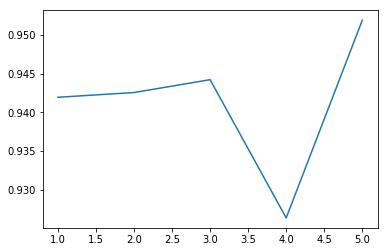

IndexError: tuple index out of range

In [13]:
trainLoop(epochs=5, lr=0.025, wd = 1e-5,print_batch_p = 1, early_patience=5)

In [ ]:
y_hat = model(Variable(torch.LongTensor(test.userId.values)),
              Variable(torch.LongTensor(test.movieId.values)))

y_hat.data.cpu().numpy().min(), y_hat.data.cpu().numpy().max()